# ResNet 과제
## 1. 기본 코드(cifar10 dataset) 돌리면서 코드 파악

## 2. 원하는 dataset 선택
- dataset에 따른 imgsize & class 개수 등 조절 필요

## 3. Parameter 바꿔가면서 성능 변화 확인하기
  - image 크기(resize)
  - learning rate
  - optimizer

<br/>
<br/>

학습시간이 너무 오래 걸리면 epoch수를 줄이고, 다양한 시도를 해보면 좋을 것!!

참고 데이터셋
- https://www.tensorflow.org/api_docs/python/tf/keras/datasets
- 그 외 원하는 이미지 데이터셋 자유롭게 사용 가능

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import tensorflow as tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## ResNet 구현
### 1. identity block을 생성하는 함수인 identity_block() 생성. 
* input_tensor : 입력 tensor

* kernel_size : kernel 크기
  - identity block 내에 있는 두개의 conv layer중 1x1 kernel이 아니고, 3x3 kernel임 (3x3 커널이 아니라 5x5 kernel도 지정할 수 있게 구성)
* filters: 3개 conv layer들의 filter개수를 list 형태로 입력 받음
  * 첫번째 : 첫번째 1x1 filter 개수 (tensor의 channel 차원을 1/4로 축소)
  * 두번째 : 3x3 filter 개수
  * 세번째 : 마지막 1x1 filter 개수 (tensor의 차원 복구)
* stage: identity block들을 구별하기 위해서 설정 & 동일한 filter수를 가지는 identity block들은 동일한 stage로 설정
* block: 동일 stage내에서 identity block을 구별하기 위한 구분자 (a,b,c)

![](https://raw.githubusercontent.com/chulminkw/CNN_PG/main/utils/images/residual_block_small.png)


In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation
from tensorflow.keras.layers import add, Add

# identity block은 shortcut 단에 conv layer가 없는 block 영역
def identity_block(input_tensor, middle_kernel_size, filters, stage, block):
    '''
    함수 입력 인자 설명
    input_tensor : 입력 tensor

    middle_kernel_size : 중간에 위치하는 kernel 크기. identity block내에 있는 두개의 conv layer중 1x1 kernel이 아니고, 3x3 kernel임. 
    (3x3 커널이 이외에도 5x5 kernel도 지정할 수 있게 구성)

    filters: 3개 conv layer들의 filter개수를 list 형태로 입력 받음. 첫번째 원소는 첫번째 1x1 filter 개수, 두번째는 3x3 filter 개수, 세번째는 마지막 1x1 filter 개수

    stage: identity block들이 여러개가 결합되므로 이를 구분하기 위해서 설정. 동일한 filter수를 가지는 identity block들을  동일한 stage로 설정.  

    block: 동일 stage내에서 identity block을 구별하기 위한 구분자
    ''' 
    
    # filters : filter 개수를 각각 filter1, filter2, filter3 list 형태로 할당. 
    # filter은 첫번째 1x1 filter 개수
    # filter2는 3x3 filter 개수
    # filter3는 마지막 1x1 filter 개수
    filter1, filter2, filter3 = filters
    
    # conv layer와 Batch normalization layer각각에 고유한 이름을 부여하기 위해 설정
    # 입력받은 stage와 block에 기반하여 이름 부여
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # 이전 layer에 입력 받은 input_tensor를 기반으로 첫번째 1x1 Conv->Batch Norm->Relu 수행. 
    # 첫번째 1x1 Conv에서 Channel Dimension Reduction(1/4) 수행
    x = Conv2D(filters=filter1, kernel_size=(1, 1), kernel_initializer='he_normal', name=conv_name_base+'2a')(input_tensor)
    x = BatchNormalization(axis=3, name=bn_name_base+'2a')(x)
    x = Activation('relu')(x)
    
    # 두번째 3x3 Conv->Batch Norm->ReLU 수행
    # 3x3이 아닌 다른 kernel size도 구성 가능할 수 있도록 identity_block() 인자로 입력받은 middle_kernel_size를 이용
    # Conv 수행 출력 사이즈가 변하지 않도록 padding='same'으로 설정
    # filter 개수는 이전의 1x1 filter개수와 동일
    x = Conv2D(filters=filter2, kernel_size=middle_kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base+'2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2b')(x)
    x = Activation('relu')(x)
    
    # 마지막 1x1 Conv->Batch Norm 수행
    # ReLU를 수행 X (input tensor 더한 이후에 ReLU 적용)
    # filter 크기는 input_tensor channel 차원 개수로 복구
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer='he_normal', name=conv_name_base+'2c')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2c')(x)

    # Residual Block 수행 결과 & input_tensor를 합 (Skip Connection)
    x = Add()([input_tensor, x])

    # 최종 ReLU 적용
    x = Activation('relu')(x)
    
    return x

### 2. 위에서 생성한 identity_block()을 호출하여 어떻게 identity block이 구성되어 있는지 확인

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# input_tensor로 임의의 Feature Map size를 생성. 
input_tensor = Input(shape=(56, 56, 256), name='test_input')

# input_tensor의 channel수는 256개
# filters는 256의 1/4 filter수로 차원 축소후 다시 마지막 1x1 Conv에서 256으로 복원
filters = [64, 64, 256]

# 중간 Conv 커널 크기 : 3x3
kernel_size = (3, 3)
stage = 2
block = 'a'

# identity_block 호출 & layer들이 어떻게 구성되어 있는지 확인하기 위해서 model로 구성하고 summary()호출 
output = identity_block(input_tensor, kernel_size, filters, stage, block)
identity_layers = Model(inputs=input_tensor, outputs=output)
identity_layers.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 test_input (InputLayer)        [(None, 56, 56, 256  0           []                               
                                )]                                                                
                                                                                                  
 res2a_branch2a (Conv2D)        (None, 56, 56, 64)   16448       ['test_input[0][0]']             
                                                                                                  
 bn2a_branch2a (BatchNormalizat  (None, 56, 56, 64)  256         ['res2a_branch2a[0][0]']         
 ion)                                                                                             
                                                                                              

### 3. identity block을 연속으로 이어서 하나의 Stage 구성.
* 아래는 input tensor의 크기가 feature map 생성시 절반으로 줄지 않음
* input tensor의 크기가 절반으로 줄수 있도록 구성
* 동일한 Stage 내에서 feature map의 크기는 그대로 & block내에서 filter 개수는 변화

In [ ]:
input_tensor = Input(shape=(56, 56, 256), name='test_input')

x = identity_block(input_tensor, middle_kernel_size=3, filters=[64, 64, 256], stage=2, block='a')
x = identity_block(x, middle_kernel_size=3, filters=[64, 64, 256], stage=2, block='b')

output = identity_block(x, middle_kernel_size=3, filters=[64, 64, 256], stage=2, block='c')

identity_layers = Model(inputs=input_tensor, outputs=output)
identity_layers.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 test_input (InputLayer)        [(None, 56, 56, 256  0           []                               
                                )]                                                                
                                                                                                  
 res2a_branch2a (Conv2D)        (None, 56, 56, 64)   16448       ['test_input[0][0]']             
                                                                                                  
 bn2a_branch2a (BatchNormalizat  (None, 56, 56, 64)  256         ['res2a_branch2a[0][0]']         
 ion)                                                                                             
                                                                                            

### 4. 각 stage내의 첫번째 identity block에서 입력 feature map의 크기를 절반으로 줄이는 conv_block() 만들기
* conv_block() 함수는 앞에서 구현한 identity_block()함수과 거의 유사
* 입력 feature map의 크기를 절반으로 줄이고 shortcut 전달시 1x1 conv & stride 2 적용
* 첫번째 Stage의 첫번째 block에서는 이미 입력 feature map이 max pool로 절반이 줄어있는 상태이므로 다시 줄이지 않음

In [ ]:
def conv_block(input_tensor, middle_kernel_size, filters, stage, block, strides=(2, 2)):
    '''
    함수 입력 인자 설명
    input_tensor: 입력 tensor

    middle_kernel_size: 중간에 위치하는 kernel 크기. identity block내에 있는 두개의 conv layer중 1x1 kernel이 아니고, 3x3 kernel임. 
                        3x3 커널 이외에도 5x5 kernel도 지정할 수 있게 구성. 

    filters: 3개 conv layer들의 filter개수를 list 형태로 입력 받음. 첫번째 원소는 첫번째 1x1 filter 개수, 두번째는 3x3 filter 개수, 
             세번째는 마지막 1x1 filter 개수

    stage: identity block들이 여러개가 결합되므로 이를 구분하기 위해서 설정. 동일한 filter수를 가지는 identity block들을  동일한 stage로 설정.  

    block: 동일 stage내에서 identity block을 구별하기 위한 구분자

    strides: 입력 feature map의 크기를 절반으로 줄이기 위해서 사용. Default는 2이지만, 
             첫번째 Stage의 첫번째 block에서는 이미 입력 feature map이 max pool로 절반이 줄어있는 상태이므로 다시 줄이지 않기 위해 1을 호출해야함 
    ''' 
    
    # filters : filter 개수를 각각 filter1, filter2, filter3 list 형태로 할당. 
    # filter은 첫번째 1x1 filter 개수
    # filter2는 3x3 filter 개수
    # filter3는 마지막 1x1 filter 개수
    filter1, filter2, filter3 = filters

    # conv layer와 Batch normalization layer각각에 고유한 이름을 부여하기 위해 설정. 입력받은 stage와 block에 기반하여 이름 부여
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # 이전 layer에 입력 받은 input_tensor를 기반으로 첫번째 1x1 Conv->Batch Norm->Relu 수행. 
    # 입력 feature map 사이즈를 1/2로 줄이기 위해 strides 입력  
    x = Conv2D(filters=filter1, kernel_size=(1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base+'2a')(input_tensor)
    
    # Batch Norm 적용
    # 입력 데이터는 batch 사이즈까지 포함하여 4차원 : (batch_size, height, width, channel depth)
    # Batch Norm의 axis는 channel depth에 해당하는 axis index인 3을 입력 (무조건 channel이 마지막 차원의 값으로 입력된다고 가정)
    x = BatchNormalization(axis=3, name=bn_name_base+'2a')(x)
    # ReLU Activation 적용
    x = Activation('relu')(x)
    
    # 두번째 3x3 Conv->Batch Norm->ReLU 수행
    # 3x3이 아닌 다른 kernel size도 구성 가능할 수 있도록 identity_block() 인자로 입력받은 middle_kernel_size를 이용. 
    # Conv 수행 출력 사이즈가 변하지 않도록 padding='same'으로 설정. filter 개수는 이전의 1x1 filter개수와 동일.  
    x = Conv2D(filters=filter2, kernel_size=middle_kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base+'2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2b')(x)
    x = Activation('relu')(x)
    
    # 마지막 1x1 Conv->Batch Norm 수행
    # ReLU를 수행 X (input tensor 더한 이후에 ReLU 적용)
    # filter 크기는 input_tensor channel 차원 개수로 복구
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer='he_normal', name=conv_name_base+'2c')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2c')(x)
    
    # shortcut을 1x1 conv 수행, filter3가 입력 feature map의 filter 개수
    shortcut = Conv2D(filter3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base+'1')(input_tensor)
    shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(shortcut)
    
    # Residual Block 수행 결과 & 1x1 conv가 적용된 shortcut을 합 
    x = add([x, shortcut])
    
    # 최종 ReLU 적용
    x = Activation('relu')(x)
    
    return x
    

### 5. conv_block()과 identity_block()을 호출하여 stage 구성.

In [ ]:
input_tensor = Input(shape=(56, 56, 256), name='test_input')

# conv_block() 호출 시 strides를 2로 설정하여 입력 feature map의 크기를 절반으로 줄임 / strides=1이면 크기를 그대로 유지
x = conv_block(input_tensor, middle_kernel_size=3, filters=[64, 64, 256], strides=2, stage=2, block='a')
x = identity_block(x, middle_kernel_size=3, filters=[64, 64, 256], stage=2, block='b')

output = identity_block(x, middle_kernel_size=3, filters=[64, 64, 256], stage=2, block='c')

identity_layers = Model(inputs=input_tensor, outputs=output)
identity_layers.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 test_input (InputLayer)        [(None, 56, 56, 256  0           []                               
                                )]                                                                
                                                                                                  
 res2a_branch2a (Conv2D)        (None, 28, 28, 64)   16448       ['test_input[0][0]']             
                                                                                                  
 bn2a_branch2a (BatchNormalizat  (None, 28, 28, 64)  256         ['res2a_branch2a[0][0]']         
 ion)                                                                                             
                                                                                            

### 6. input image를 7x7 Conv 변환하고 Max Pooling 적용 로직을 별도 함수로 구현.
* O = (I - F + 2P)/S + 1, I는 Input size, F는 filter의 kernel 크기, P는 padding, S는 Stride
* (224 - 7)/2 + 1 = 109.5 = 109가 됨. 따라서 112x112 로 출력하기 위해 ZeroPadding2D(3, 3)수행
* 112x112로 MaxPooling 을 (3, 3) pool size로 stride 2로 수행하므로 56x56으로 출력하기 위해 ZeroPadding2D(1,1) 수행

In [ ]:
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D

def do_first_conv(input_tensor):
    # 7x7 Conv 연산 수행하여 feature map 생성, input_tensor 크기를 절반으로 생성
    # filter 개수 : 64개 
    # 224x224 를 input -> 7x7 conv, strides=2 -> 112x112 출력 (Zero padding 적용)
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(input_tensor)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv')(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)

    # 다시 feature map 크기를 MaxPooling으로 절반으로 만듬 -> 56x56으로 출력 (zero padding 적용)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    return x

input_tensor = Input(shape=(224, 224, 3))
output = do_first_conv(input_tensor)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)       0         
                                                                 
 conv (Conv2D)               (None, 112, 112, 64)      9472      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 112, 112, 64)     256       
 n)                                                              
                                                                 
 activation_21 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)      0         
                                                           

### 7. ResNet 50 모델 생성.
* 앞에서 생성한 conv_block()과 identity_block()을 호출하여 ResNet 50 모델 생성. 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_resnet(in_shape=(224, 224, 3), n_classes=10):
    input_tensor = Input(shape=in_shape)
    
    # 첫번째 7x7 Conv와 Max Pooling 적용.  
    x = do_first_conv(input_tensor)
    
    # stage 2의 conv_block과 identity block 생성
    # stage2의 첫번째 conv_block은 strides를 1로 하여 크기를 줄이지 않음. 
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    # stage 3의 conv_block과 identity block 생성
    # stage3의 첫번째 conv_block은 strides를 2(default)로 하여 크기를 줄임 
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    # stage 4의 conv_block과 identity block 생성
    # stage4의 첫번째 conv_block은 strides를 2(default)로 하여 크기를 줄임
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # stage 5의 conv_block과 identity block 생성
    # stage5의 첫번째 conv_block은 strides를 2(default)로 하여 크기를 줄임
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    # classification dense layer와 연결 전 GlobalAveragePooling 수행 
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(200, activation='relu', name='fc_01')(x)
    x = Dropout(rate=0.5)(x)
   
    # 마지막 fully connected layer & Softmax 함수를 이용해 확률 반환
    output = Dense(n_classes, activation='softmax', name='fc_final')(x) 
    
    # model 구성
    model = Model(inputs=input_tensor, outputs=output, name='resnet50')
    model.summary()
    
    return model

In [ ]:
model =  create_resnet(in_shape=(224,224,3), n_classes=10)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv (Conv2D)                  (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## CIFAR10 데이터 세트로 ResNet 모델 학습 및 성능 테스트

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 64

### 데이터 전처리/인코딩/스케일링 함수 및 CIFAR_Dataset 선언

In [ ]:
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import Sequence
import cv2
import sklearn

def zero_one_scaler(image):
    return image/255.0

# One Hot Encoding(OHE)
def get_preprocessed_ohe(images, labels, pre_func=None):
    # preprocessing 함수가 입력되면 이를 이용하여 image array를 scaling 적용.
    if pre_func is not None:
        images = pre_func(images)
    # OHE 적용    
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42):

    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경
    # Label에 대해서는 OHE 적용
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # train valid split
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )

from tensorflow.keras.utils import Sequence
import cv2
import sklearn

# 입력 인자 images_array labels는 모두 numpy array로 들어옴 (images_array는 32x32)
class CIFAR_Dataset(Sequence):
    def __init__(self, images_array, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명

        images_array : 원본 32x32 만큼의 image 배열값. 

        labels : 해당 image의 label

        batch_size : __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수

        augmentor : albumentations 객체

        shuffle : 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        # 인자로 입력되는 images_array는 전체 32x32 image array임.
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func

        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels) / self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환 후 반환
    # index(몇번째 배치이지) -> 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환
    # batch_size 개수만큼 image_array와 label_array 반환
    def __getitem__(self, index):
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size : (index+1)*self.batch_size 만큼 가져옴
        # 32x32 image array를 self.batch_size만큼 가져옴. 
        images_fetch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]

        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # albumentation으로 만든 augmentor가 주어진다면 augmentor를 이용
        # albumentations : image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행 
        # 변환된 image 배열값을 담을 image_batch 선언 & image_batch 배열은 float32 로 설정 
        image_batch = np.zeros((images_fetch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환
        # augmentor가 not None일 경우 -> image_batch에 담음
        for image_index in range(images_fetch.shape[0]):
            #image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            
            # 원본 image를 IMAGE_SIZE x IMAGE_SIZE 크기로 변환
            image = cv2.resize(images_fetch[image_index], (IMAGE_SIZE, IMAGE_SIZE))

            # 만약 augmentor가 주어졌다면 이를 적용. 
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                
            # 만약 scaling 함수가 입력되었다면 이를 적용하여 scaling 수행. 
            if self.pre_func is not None:
                image = self.pre_func(image)
            
            # image_batch에 순차적으로 변환된 image를 담음.               
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 원본 image배열과 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)
        else:
            pass


### 원-핫 인코딩, 학습/검증/테스트 데이터 세트 분할
* scaling은 원본 채널별 pixel값 - [103.939, 116.779, 123.68] 적용.



In [ ]:
# CIFAR10 데이터 재 로딩 및 OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.2, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170498071/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


### 학습, 검증용 CIFAR_Dataset 생성

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

tr_ds = CIFAR_Dataset(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=True, pre_func=resnet_preprocess)
val_ds = CIFAR_Dataset(val_images, val_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=resnet_preprocess)

print(next(iter(tr_ds))[0].shape, next(iter(val_ds))[0].shape)
print(next(iter(tr_ds))[1].shape, next(iter(val_ds))[1].shape)
# 채널별 값 - [103.939, 116.779, 123.68]
print(next(iter(tr_ds))[0][0])

(64, 128, 128, 3) (64, 128, 128, 3)
(64, 10) (64, 10)
[[[ 73.061     57.221     40.32    ]
  [ 73.061     57.221     40.32    ]
  [ 70.061     54.221     38.32    ]
  ...
  [-34.939003 -42.779    -50.68    ]
  [-35.939003 -44.779    -53.68    ]
  [-35.939003 -44.779    -53.68    ]]

 [[ 73.061     57.221     40.32    ]
  [ 73.061     57.221     40.32    ]
  [ 70.061     54.221     38.32    ]
  ...
  [-34.939003 -42.779    -50.68    ]
  [-35.939003 -44.779    -53.68    ]
  [-35.939003 -44.779    -53.68    ]]

 [[ 75.061     59.221     42.32    ]
  [ 75.061     59.221     42.32    ]
  [ 72.061     56.221     40.32    ]
  ...
  [-34.939003 -42.779    -50.68    ]
  [-35.939003 -44.779    -52.68    ]
  [-35.939003 -44.779    -52.68    ]]

 ...

 [[120.061    102.221    109.32    ]
  [120.061    102.221    109.32    ]
  [116.061     99.221    107.32    ]
  ...
  [-35.939003 -44.779    -55.68    ]
  [-34.939003 -43.779    -53.68    ]
  [-34.939003 -43.779    -53.68    ]]

 [[121.061    103.22

### 1) ResNet50 (모델 생성) 후 학습/평가
* 초기 learning_rate 0.001



In [ ]:
resnet_model = create_resnet(in_shape=(128, 128, 3), n_classes=10)

resnet_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = resnet_model.fit(tr_ds, epochs=10, 
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=val_ds, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv (Conv2D)                  (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 64, 64, 64)   256         ['conv[0][0]']            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
625/625 [==============================] - 170s 249ms/step - loss: 1.9743 - accuracy: 0.2596 - val_loss: 2.3057 - val_accuracy: 0.1695 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 158s 253ms/step - loss: 1.6168 - accuracy: 0.3933 - val_loss: 2.7246 - val_accuracy: 0.3460 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 160s 255ms/step - loss: 1.4746 - accuracy: 0.4561 - val_loss: 1.5406 - val_accuracy: 0.4825 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 160s 256ms/step - loss: 1.3138 - accuracy: 0.5242 - val_loss: 1.2353 - val_accuracy: 0.5584 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 160s 256ms/step - loss: 1.1594 - accuracy: 0.5944 - val_loss: 1.1250 - val_accuracy: 0.6084 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 161s 257ms/step - loss: 1.0294 - accuracy: 0.6435 - val_loss: 1.1829 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 7/10
625/625 [==========================

In [ ]:
test_ds = CIFAR_Dataset(test_images, test_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=resnet_preprocess)
resnet_model.evaluate(test_ds)

157/157 [==============================] - 11s 72ms/step - loss: 0.7324 - accuracy: 0.7570


[0.7323887944221497, 0.7570000290870667]

### 2) ResNet50 (Pretrained 모델)로 학습/평가

In [ ]:
from tensorflow.keras.applications import ResNet50

input_tensor = Input(shape=(128, 128, 3))
base_model = ResNet50(include_top=False, weights=None, input_tensor=input_tensor)
bm_output = base_model.output

# classification dense layer와 연결 전 GlobalAveragePooling 수행 
x = GlobalAveragePooling2D(name='avg_pool')(bm_output)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu', name='fc_01')(x)
x = Dropout(rate=0.5)(x)
output = Dense(10, activation='softmax', name='fc_final')(x)

pr_model = Model(inputs=input_tensor, outputs=output, name='resnet50')
pr_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
pr_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = pr_model.fit(tr_ds, epochs=10, 
                    validation_data=val_ds,
                    callbacks=[rlr_cb, ely_cb]
                   )

test_ds = CIFAR_Dataset(test_images, test_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=resnet_preprocess)
pr_model.evaluate(test_ds)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


625/625 [==============================] - 166s 257ms/step - loss: 2.2287 - accuracy: 0.1890 - val_loss: 1.8798 - val_accuracy: 0.2994 - lr: 1.0000e-04
Epoch 2/10
625/625 [==============================] - 160s 256ms/step - loss: 1.8224 - accuracy: 0.3186 - val_loss: 1.6041 - val_accuracy: 0.4008 - lr: 1.0000e-04
Epoch 3/10
625/625 [==============================] - 160s 256ms/step - loss: 1.6091 - accuracy: 0.4162 - val_loss: 1.5172 - val_accuracy: 0.4345 - lr: 1.0000e-04
Epoch 4/10
625/625 [==============================] - 160s 256ms/step - loss: 1.4384 - accuracy: 0.4870 - val_loss: 1.2474 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 5/10
625/625 [==============================] - 160s 257ms/step - loss: 1.2988 - accuracy: 0.5447 - val_loss: 1.2001 - val_accuracy: 0.5614 - lr: 1.0000e-04
Epoch 6/10
625/625 [==============================] - 160s 256ms/step - loss: 1.1538 - accuracy: 0.6006 - val_loss: 1.1385 - val_accuracy: 0.6039 - lr: 1.0000e-04
Epoch 7/10
625/625 [=============

[0.9097848534584045, 0.6996999979019165]

# Rock Paper Scissors 데이터셋에 ResNet 적용해보기
사용 데이터셋 출처: https://www.tensorflow.org/datasets/catalog/rock_paper_scissors?hl=ko

### 데이터 불러오기 및 탐색

In [ ]:
# 데이터 불러오기
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    # shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [ ]:
image_shape = ds_info.features['image'].shape
image_dtype = ds_info.features['image'].dtype

print(f'image shape: {image_shape}')
print(f'image dtype: {image_dtype}')

image shape: (300, 300, 3)
image dtype: <dtype: 'uint8'>


In [ ]:
num_train = ds_info.splits['train'].num_examples
print(f'num of train: {num_train}')

num_test = ds_info.splits['test'].num_examples
print(f'num of test : {num_test}')

num of train: 2520
num of test : 372


In [ ]:
# training set을 training과 validation set으로 나눔 (8:2)
def get_validation(ds, ds_size, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds


In [ ]:
ds_train, ds_val = get_validation(ds_train, num_train)

In [ ]:
# 데이터 시각화 함수 정의
get_label_name = ds_info.features['label'].int2str

def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

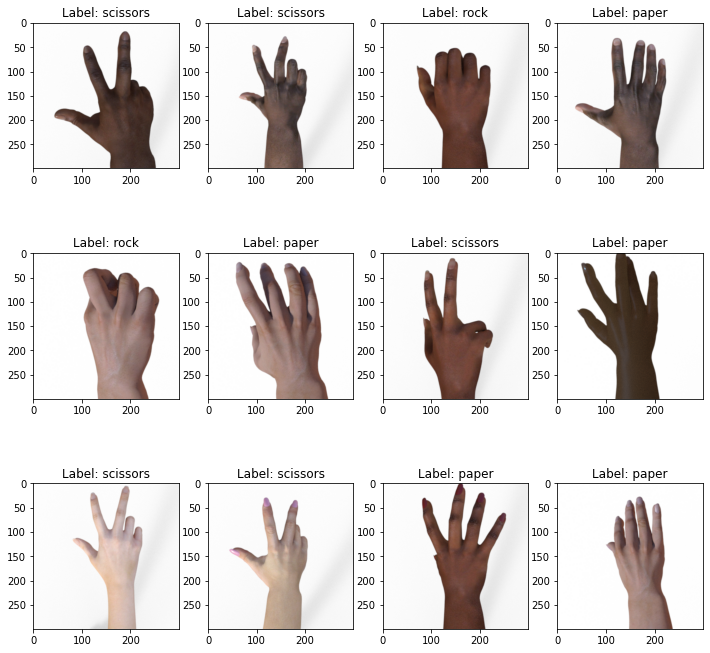

In [ ]:
preview_dataset(ds_train)

### 데이터 전처리

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

In [ ]:
INPUT_IMG_SIZE = 128

# 데이터 정규화 함수 정의
def normalize_img(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [ ]:
ds_train = ds_train.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(num_train)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = ds_val.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(num_train)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 학습

In [ ]:
resnet_model = create_resnet(in_shape=(128, 128, 3), n_classes=3)

resnet_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = resnet_model.fit(ds_train, epochs=10, 
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=ds_val, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv (Conv2D)                  (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 64, 64, 64)   256         ['conv[0][0]']            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/63 [==============================] - 20s 149ms/step - loss: 1.2379 - accuracy: 0.5109 - val_loss: 5193.6973 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 8s 132ms/step - loss: 0.2175 - accuracy: 0.9266 - val_loss: 5.3825 - val_accuracy: 0.4147 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 8s 132ms/step - loss: 0.0674 - accuracy: 0.9802 - val_loss: 4.7943 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 8s 133ms/step - loss: 0.0551 - accuracy: 0.9826 - val_loss: 1.1185 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 8s 133ms/step - loss: 0.0492 - accuracy: 0.9821 - val_loss: 0.1538 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 8s 132ms/step - loss: 0.0365 - accuracy: 0.9876 - val_loss: 0.1110 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 8s 132ms/step - loss: 0.0

### 모델 평가

In [ ]:
resnet_model.evaluate(ds_test)

12/12 [==============================] - 2s 125ms/step - loss: 0.8427 - accuracy: 0.8468


[0.8427240252494812, 0.8467742204666138]

## Parameter를 조정해가며 모델 학습

### learning rate 조정

In [ ]:
# learning rate = 0.0001
resnet_model = create_resnet(in_shape=(128, 128, 3), n_classes=3)

resnet_model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = resnet_model.fit(ds_train, epochs=10, 
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=ds_val, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv (Conv2D)                  (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 64, 64, 64)   256         ['conv[0][0]']            

모델 평가

In [ ]:
resnet_model.evaluate(ds_test)

12/12 [==============================] - 1s 45ms/step - loss: 2.3338 - accuracy: 0.6183


[2.333807945251465, 0.6182795763015747]

### optimzer 조정

In [ ]:
# optimizer = SGD
from tensorflow.keras.optimizers import SGD

resnet_model = create_resnet(in_shape=(128, 128, 3), n_classes=3)

resnet_model.compile(optimizer=SGD(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = resnet_model.fit(ds_train, epochs=10, 
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=ds_val, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv (Conv2D)                  (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 64, 64, 64)   256         ['conv[0][0]']            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


63/63 [==============================] - 13s 141ms/step - loss: 2.0020 - accuracy: 0.3323 - val_loss: 10.7430 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 8s 128ms/step - loss: 1.5716 - accuracy: 0.3616 - val_loss: 1.1017 - val_accuracy: 0.3591 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 8s 130ms/step - loss: 1.4728 - accuracy: 0.3606 - val_loss: 1.5453 - val_accuracy: 0.3254 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 8s 130ms/step - loss: 1.3377 - accuracy: 0.3715 - val_loss: 1.2135 - val_accuracy: 0.3254 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - ETA: 0s - loss: 1.2668 - accuracy: 0.3705
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
63/63 [==============================] - 8s 131ms/step - loss: 1.2668 - accuracy: 0.3705 - val_loss: 1.2819 - val_accuracy: 0.3512 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 8s 130ms/step - loss: 

In [ ]:
resnet_model.evaluate(ds_test)

12/12 [==============================] - 1s 43ms/step - loss: 1.1033 - accuracy: 0.3495


[1.103329062461853, 0.3494623601436615]

In [ ]:
# optimizer = Adagrad
from tensorflow.keras.optimizers import Adagrad

resnet_model = create_resnet(in_shape=(128, 128, 3), n_classes=3)

resnet_model.compile(optimizer=Adagrad(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = resnet_model.fit(ds_train, epochs=10, 
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=ds_val, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv (Conv2D)                  (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 64, 64, 64)   256         ['conv[0][0]']            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


63/63 [==============================] - 15s 144ms/step - loss: 1.7065 - accuracy: 0.3571 - val_loss: 7.8038 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 8s 132ms/step - loss: 1.3121 - accuracy: 0.3894 - val_loss: 1.1097 - val_accuracy: 0.3532 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 8s 132ms/step - loss: 1.1814 - accuracy: 0.3988 - val_loss: 1.1067 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 9s 138ms/step - loss: 1.1239 - accuracy: 0.4211 - val_loss: 1.0995 - val_accuracy: 0.3234 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 9s 135ms/step - loss: 1.0794 - accuracy: 0.4266 - val_loss: 1.0978 - val_accuracy: 0.3353 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 9s 135ms/step - loss: 1.0637 - accuracy: 0.4360 - val_loss: 1.0786 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 9s 136ms/step - loss: 1.0555

In [ ]:
resnet_model.evaluate(ds_test)

12/12 [==============================] - 1s 43ms/step - loss: 1.0901 - accuracy: 0.4005


[1.0900825262069702, 0.4005376398563385]

### image size 조정

In [ ]:
# image size 128 -> 100으로 조정
INPUT_IMG_SIZE = 100

# 데이터 정규화 함수 정의
def normalize_img(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [ ]:
ds_train = ds_train.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(num_train)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = ds_val.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(num_train)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
resnet_model = create_resnet(in_shape=(100, 100, 3), n_classes=3)

resnet_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = resnet_model.fit(ds_train, epochs=10, 
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=ds_val, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv (Conv2D)                  (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 50, 50, 64)   256         ['conv[0][0]']            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/63 [==============================] - 22s 127ms/step - loss: 1.1675 - accuracy: 0.5124 - val_loss: 1148.6176 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 108ms/step - loss: 0.2925 - accuracy: 0.8805 - val_loss: 3.2772 - val_accuracy: 0.4226 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 110ms/step - loss: 0.1187 - accuracy: 0.9643 - val_loss: 2.5698 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 7s 109ms/step - loss: 0.0678 - accuracy: 0.9831 - val_loss: 0.5529 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 7s 108ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.6315 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 7s 110ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0343 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 7s 108ms/step - loss: 7.3

In [ ]:
resnet_model.evaluate(ds_test)

12/12 [==============================] - 2s 183ms/step - loss: 5.2644 - accuracy: 0.6505


[5.264397144317627, 0.6505376100540161]